# Structure quality

This notebook explores the impact of the structure quality on the performance of the docking algorithms **Fred**, **Hybrid** and **Posit**. The [irdium score](https://docs.eyesopen.com/toolkits/python/sprucetk/theory/iridium.html) from OpenEye will be used as a measure of structure quality.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)
docking_benchmark_dataset = pd.read_csv("../data/docking_benchmark_dataset.csv", index_col=0)
# fix 'NA' category
nan_indices = docking_benchmark_dataset["iridium_category"].isna()
docking_benchmark_dataset.loc[nan_indices[nan_indices].index.values, "iridium_category"] = "NA"
print(f"Total number of structures in benchmark: {len(docking_benchmark_dataset)}")
for quality_group in ["HT", "MT", "NT", "NA"]:
    n_structures = sum(docking_benchmark_dataset["iridium_category"] == quality_group)
    print(f"Number of structures in benchmark in iridium category {quality_group}: {n_structures}")

Total number of structures in benchmark: 589
Number of structures in benchmark in iridium category HT: 138
Number of structures in benchmark in iridium category MT: 360
Number of structures in benchmark in iridium category NT: 4
Number of structures in benchmark in iridium category NA: 87


## Impact of structure quality on docking performance

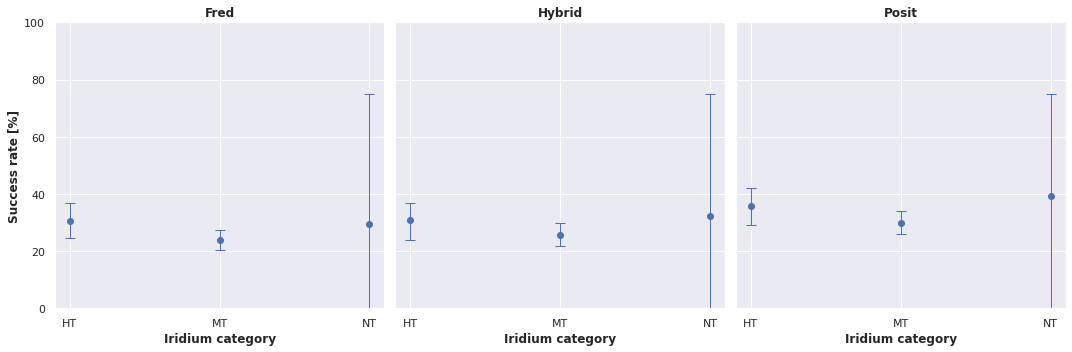

In [5]:
def plot_performance(docking_benchmark_dataset, fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 3 subplots
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    
    # sample success rates
    sampled_success_rates = []
    quality_groups = ["HT", "MT", "NT"]
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for quality_group in quality_groups:
            group_pdb_ids = docking_benchmark_dataset[
                docking_benchmark_dataset["iridium_category"] == quality_group
            ]["structure.pdb_id"].to_list()
            result_selection = results[results["ligand_pdb_id"].isin(group_pdb_ids)]
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_results = result_selection.groupby("ligand_pdb_id").sample(n=1, replace=True)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([quality_group, method, mean, lower_bound, upper_bound])
            
    # plot sampled data
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, 
        columns=["quality_group", "method", "success_rate", "ci_lower", "ci_upper"]
    )
    for i, method in enumerate(["Fred", "Hybrid", "Posit"]):
        sampled_success_rates_i = sampled_success_rates[sampled_success_rates["method"] == method]
        axes[i].errorbar(
            x=sampled_success_rates_i["quality_group"],
            y=sampled_success_rates_i["success_rate"],
            yerr=[
                sampled_success_rates_i["success_rate"] - sampled_success_rates_i["ci_lower"], 
                sampled_success_rates_i["ci_upper"] - sampled_success_rates_i["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1
        )
        axes[i].set_xlabel("Iridium category", fontweight="bold")
        axes[i].set_title(method, fontweight="bold")
    axes[0].set_ylim([0, 100])
    axes[0].set_ylabel("Success rate [%]", fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(directory / "structure_quality_impact.pdf", dpi=300)
    
    return sampled_success_rates
        
        
sampled_success_rates = plot_performance(docking_benchmark_dataset, fred_results, hybrid_results, posit_results)

In [6]:
sampled_success_rates

,quality_group,method,success_rate,ci_lower,ci_upper
0,HT,Fred,30.539855,24.637681,36.956522
1,MT,Fred,23.732222,20.277778,27.500000
2,NT,Fred,29.475000,0.000000,75.000000
3,HT,Hybrid,30.786957,23.913043,36.956522
4,MT,Hybrid,25.790278,21.666667,30.000000
5,NT,Hybrid,32.325000,0.000000,75.000000
6,HT,Posit,35.693478,28.985507,42.028986
7,MT,Posit,29.888333,25.833333,34.166667
8,NT,Posit,39.225000,0.000000,75.000000
